 ---------------------------------------------------------
## 1. IMPORT LIBRARY
 ---------------------------------------------------------
 Pada tahap ini, kita memanggil semua library yang diperlukan
 untuk memuat dataset, preprocessing gambar, membuat model CNN,
 serta visualisasi.

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os


 ---------------------------------------------------------
 2. LOAD DATASET YANG SUDAH DIBAGI (TRAIN & TEST)
 ---------------------------------------------------------
 Kita memasukkan path folder dataset.
 Dataset kamu berada di folder Tomato Leaf Disease.
 Pastikan di dalamnya sudah ada folder: train/ dan test/

Found 15064 files belonging to 10 classes.
Kelas: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


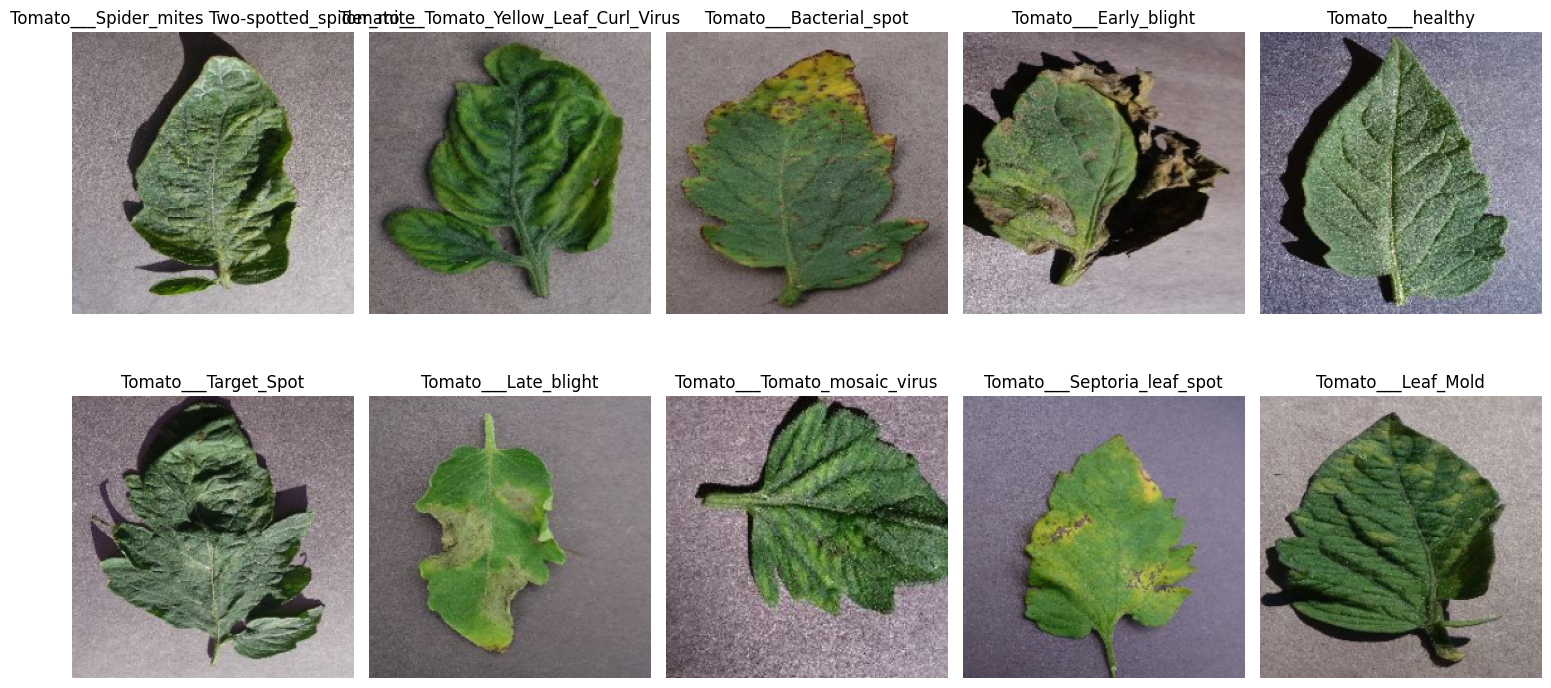

In [20]:

train_dir ="Tomato Leaf Disease/train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=50,     # lebih besar supaya dapat semua kelas
    shuffle=True
)

class_names = train_ds.class_names
print("Kelas:", class_names)

# Ambil batch pertama
for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 8))

    shown_classes = set()
    index = 1

    for i in range(len(images)):
        label = labels[i].numpy()
        class_name = class_names[label]

        # Tampilkan hanya 1 gambar per kelas
        if class_name not in shown_classes:
            plt.subplot(2, 5, index)   # 2 baris x 5 kolom = 10 gambar
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")

            shown_classes.add(class_name)
            index += 1

        # Jika sudah 10 kelas, stop
        if len(shown_classes) == 10:
            break

    plt.tight_layout()
    plt.show()
    break

 ---------------------------------------------------------
 # 3. PREPROCESSING DENGAN ImageDataGenerator
 ---------------------------------------------------------
 Pada bagian ini kita melakukan:
   - Resize gambar
   - Normalisasi pixel (0–255 menjadi 0–1)
   - Augmentasi untuk data training


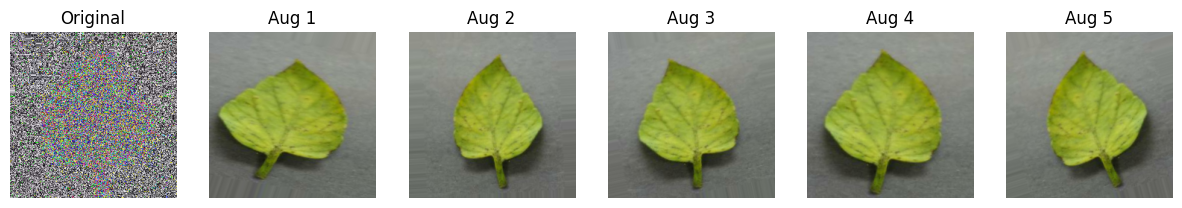

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Buat generator AUGMENTASI TANPA RESCALE
# ---------------------------
augment_only = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# ---------------------------
# Ambil 1 gambar dari TRAIN
# ---------------------------
images, labels = next(train_data)
original = images[0]   # sudah 0–1
original_uint8 = (original * 255).astype("uint8")

# ---------------------------
# Generate 5 augmentasi acak (dengan deteksi normalisasi)
# ---------------------------
augmented_images = []

for i in range(5):
    aug_batch = next(augment_only.flow(
        np.expand_dims(original, axis=0),
        batch_size=1
    ))

    aug_img = aug_batch[0]

    # DETEKSI otomatis apakah perlu normalisasi
    if aug_img.max() > 1.0:
        # berarti 0–255, normalisasi dulu
        aug_img_norm = aug_img / 255.0
    else:
        # sudah 0–1, jangan normalisasi lagi
        aug_img_norm = aug_img

    # tampilkan dalam format RGB uint8
    aug_img_uint8 = (aug_img_norm * 255).astype("uint8")
    augmented_images.append(aug_img_uint8)

# ---------------------------
# Plot grid
# ---------------------------
plt.figure(figsize=(15, 4))

plt.subplot(1, 6, 1)
plt.imshow(original_uint8)
plt.title("Original")
plt.axis("off")

for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.imshow(augmented_images[i])
    plt.title(f"Aug {i+1}")
    plt.axis("off")

plt.show()

In [22]:
# Analisis Eksplorasi Data (EDA)

# 1. Menampilkan daftar kelas
print("Kelas dalam dataset:", class_names)

# 2. Menghitung jumlah gambar per kelas
class_counts = {}
total_images = 0

for images, labels in train_ds:
    for label in labels:
        class_name = class_names[label.numpy()]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1
        total_images += 1

print("Jumlah gambar per kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

print(f"Total Files: {total_images}")

Kelas dalam dataset: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Jumlah gambar per kelas:
Tomato___Bacterial_spot: 1701 gambar
Tomato___Early_blight: 800 gambar
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4285 gambar
Tomato___Spider_mites Two-spotted_spider_mite: 1340 gambar
Tomato___Target_Spot: 1123 gambar
Tomato___healthy: 1272 gambar
Tomato___Tomato_mosaic_virus: 800 gambar
Tomato___Septoria_leaf_spot: 1416 gambar
Tomato___Leaf_Mold: 800 gambar
Tomato___Late_blight: 1527 gambar
Total Files: 15064


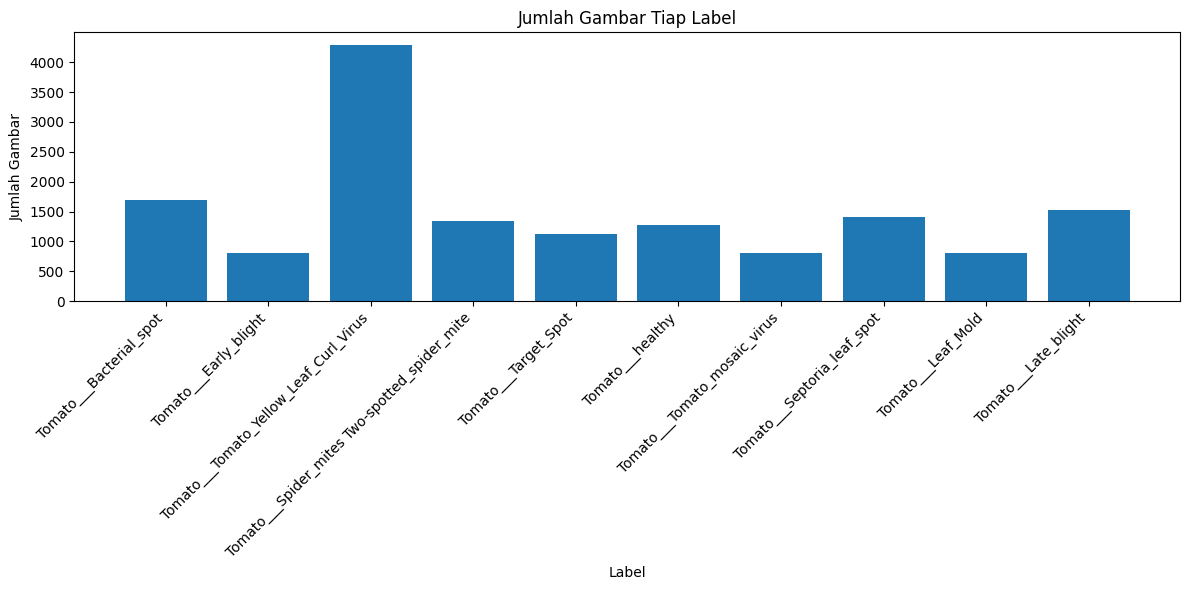

In [23]:
# 3. Visualisasi jumlah gambar tiap kelas
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Jumlah Gambar Tiap Label")
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

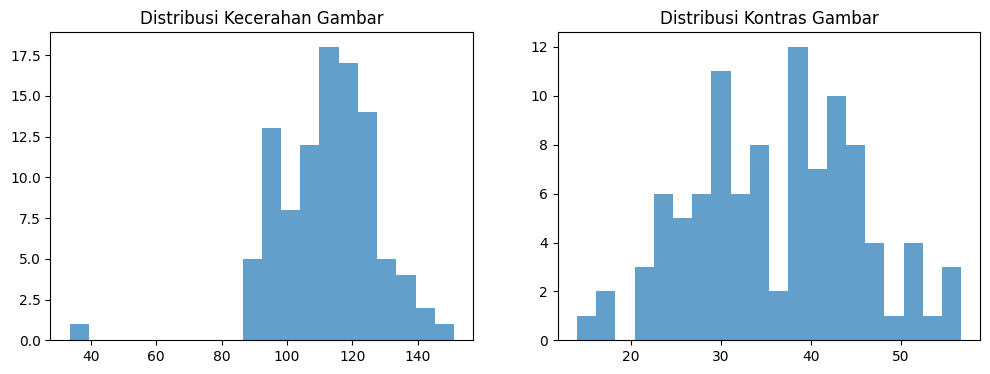

In [24]:
# Cek kecerahan dan kontras
brightness = []
contrast = []

for images, labels in train_ds.take(2):
    for img in images:
        img_gray = tf.image.rgb_to_grayscale(img)
        brightness.append(tf.reduce_mean(img_gray).numpy())
        contrast.append(tf.math.reduce_std(img_gray).numpy())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(brightness, bins=20, alpha=0.7)
plt.title('Distribusi Kecerahan Gambar')

plt.subplot(1, 2, 2)
plt.hist(contrast, bins=20, alpha=0.7)
plt.title('Distribusi Kontras Gambar')
plt.show()

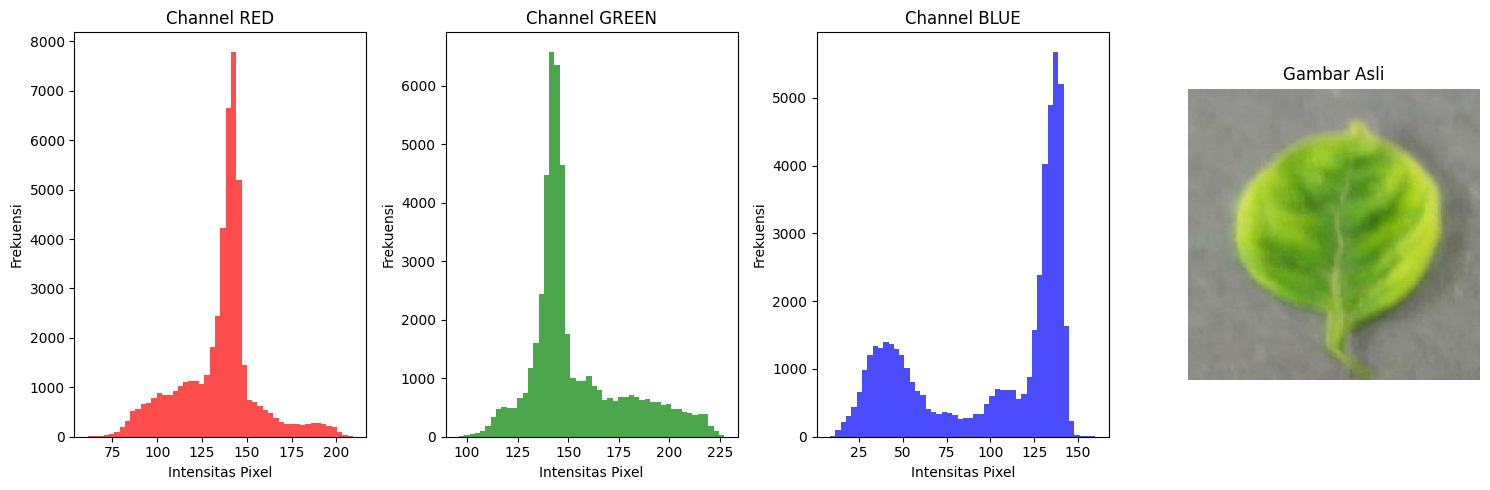

In [25]:
# Analisis distribusi warna per channel
for images, labels in train_ds.take(1):
    sample_img = images[0].numpy()
    
    plt.figure(figsize=(15, 5))
    colors = ['red', 'green', 'blue']
    
    for i in range(3):
        plt.subplot(1, 4, i+1)
        plt.hist(sample_img[:,:,i].flatten(), bins=50, color=colors[i], alpha=0.7)
        plt.title(f'Channel {colors[i].upper()}')
        plt.xlabel('Intensitas Pixel')
        plt.ylabel('Frekuensi')
    
    plt.subplot(1, 4, 4)
    plt.imshow(sample_img.astype("uint8"))
    plt.title('Gambar Asli')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()